In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import re
import seaborn as sns

# 1. Load canonical project database

In [2]:
df = pd.read_pickle("data/projects.pickle")
df.head(1).T

Project Name                                                                           Protocol Guild
Category                                                                               Infrastructure
OP Received                                                                                  557301.0
Project Profile                                     https://app.optimism.io/retropgf-discovery/0x4...
PayoutAddress                                              0x42a43f000adc215af8B1896Ed09C2d1B0f81cDfB
NominationUrl                                       https://gov.optimism.io/t/infrastructure-depen...
Website                                              https://protocol-guild.readthedocs.io/en/latest/
Twitter                                                             https://twitter.com/ProtocolGuild
Github                                                               https://github.com/protocolguild
Project Description                                 The Protocol Guild helps Ethereum's ecosystem ...
How do you support development and usage of the...  As a rollup, Optimism will leverage Ethereum f...
How do you sustain yourself? Please list source...  Just as Ethereum doesn't allocate a % of block...
Team Size                                           128 members, 22 teams: https://bit.ly/PG-membe...
Github Owner                                                                            protocolguild
Github Is Org?                                                                                   True
Verified Address                                           0x42a43f000adc215af8B1896Ed09C2d1B0f81cDfB
Address Type                                                                            Contract (OP)
ENS                                                                                              None
ETH Tx Count                                                                                      0.0
OP Tx Count                                                                                       1.0
Team Size Estimate                                                                              128.0

# 2. Assign categories to projects

In [3]:
def assign_entity(name, data):
    
    if data['Github Owner'] == 'ethereum' or name == 'Protocol Guild':
        return "Ethereum Repo"
    if 'collection' in name.lower():
        return "Collection (No Repo)"
    if data['Github Is Org?']:
        return "Organization Repo"
    if data['Github Owner'] is not None:
        return "Personal Repo"
    return "Other (No Repo)"

df['Entity'] = [assign_entity(name, data) for name, data in df.iterrows()]

In [4]:
df['Entity'].unique()

array(['Ethereum Repo', 'Organization Repo', 'Personal Repo',
       'Collection (No Repo)', 'Other (No Repo)'], dtype=object)

In [5]:
df['Category'].value_counts()

Category
Tooling and utilities    82
Education                70
Infrastructure           43
Name: count, dtype: int64

In [6]:
df.groupby('Category')['OP Received'].sum() / 10000000

Category
Education                0.306466
Infrastructure           0.370633
Tooling and utilities    0.322901
Name: OP Received, dtype: float64

In [7]:
df['Entity'].value_counts()

Entity
Organization Repo       95
Other (No Repo)         46
Personal Repo           44
Ethereum Repo            5
Collection (No Repo)     5
Name: count, dtype: int64

In [8]:
df.pivot_table(index='Entity', columns='Category', values='OP Received', aggfunc='count')

Category              Education  Infrastructure  Tooling and utilities
Entity                                                                
Collection (No Repo)        3.0             2.0                    NaN
Ethereum Repo               NaN             3.0                    2.0
Organization Repo          17.0            26.0                   52.0
Other (No Repo)            33.0             7.0                    6.0
Personal Repo              17.0             5.0                   22.0

In [9]:
summary = round(df.pivot_table(
                    index='Entity', 
                    columns='Category', 
                    values='OP Received', 
                    aggfunc='sum', 
                    fill_value=0) / 1000000, 2)
summary

Category              Education  Infrastructure  Tooling and utilities
Entity                                                                
Collection (No Repo)       0.23            0.38                   0.00
Ethereum Repo              0.00            1.01                   0.18
Organization Repo          1.51            1.70                   2.33
Other (No Repo)            0.95            0.19                   0.07
Personal Repo              0.37            0.42                   0.65

In [10]:
summary.sum(axis=1)

Entity
Collection (No Repo)    0.61
Ethereum Repo           1.19
Organization Repo       5.54
Other (No Repo)         1.21
Personal Repo           1.44
dtype: float64

In [11]:
def assign_address_category(a_type, eth_tx, op_tx):
    if a_type in ['Contract (OP)', 'Safe (OP)']:
        return "Contract (OP)"
    if a_type in ['Safe']:
        return "Contract (ETH)"
    if a_type == 'EOA':
        if op_tx >= 10:
            return 'EOA (active on OP)'
        if eth_tx >= 10:
            return 'EOA (active on Mainnet)'
        return 'EOA (low activity)'
    return "Unknown"
        
df['Address Tag'] = df.apply(
    lambda x: assign_address_category(x['Address Type'], x['ETH Tx Count'], x['OP Tx Count']), axis=1)   

In [12]:
df['Address Tag'].value_counts()

Address Tag
EOA (active on OP)         66
EOA (low activity)         45
EOA (active on Mainnet)    44
Contract (OP)              31
Unknown                     7
Contract (ETH)              2
Name: count, dtype: int64

In [13]:
def assign_teamsize_category(x):
    if np.isnan(x):
        return "Unknown"
    if x == 1:
        return "Solo"
    elif x <= 10:
        return "Small Team (2-10 ppl)"
    else:
        return "Big Team (10+ ppl)"

df['Team Size Category'] = df['Team Size Estimate'].apply(assign_teamsize_category)
df['Team Size Category'].value_counts()

Team Size Category
Small Team (2-10 ppl)    100
Solo                      47
Big Team (10+ ppl)        45
Unknown                    3
Name: count, dtype: int64

In [14]:
df['Address Tag'].value_counts()

Address Tag
EOA (active on OP)         66
EOA (low activity)         45
EOA (active on Mainnet)    44
Contract (OP)              31
Unknown                     7
Contract (ETH)              2
Name: count, dtype: int64

In [15]:
active_wallets = (~df['Address Tag'].isin(["Unknown", "EOA (low activity)"]))
github_orgs = (df['Entity'] == 'Organization Repo')

df[active_wallets]
df[github_orgs]
len(df[github_orgs & active_wallets])

66

# 3. Add Github Analysis

In [16]:
ordered_projects = df[df['Entity'] == 'Organization Repo']['OP Received'].sort_values(ascending=False).index

In [17]:
macs = pd.read_csv("data/supabase_chcbavgmufxydcwcrgye_Demo_ MAUs.csv")
macs['month'] = macs['month'].apply(lambda x: x[:7])
macs = macs.pivot_table(index='project_name', columns='month', values='active_contributors', fill_value=0)
avg_macs = macs.mean(axis=1)
avg_macs.name = "MACs"

In [18]:
mprs = pd.read_csv("data/supabase_chcbavgmufxydcwcrgye_Demo_ Merged PRs by Month.csv")
mprs['month'] = mprs['event_month'].apply(lambda x: x[:7])
mprs = mprs.pivot_table(index='project_name', columns='month', values='merged_pr_count', fill_value=0)
years = (mprs > 0).sum(axis=1) / 12
years.name = 'Age (Years)'

In [19]:
github_stats_df = pd.concat([
    df.reindex(ordered_projects)[['OP Received', 'Category', 'Team Size Estimate']],     
    avg_macs,
    years],
    axis=1)
github_stats_df = github_stats_df[github_stats_df['OP Received'] > 0]
github_stats_df.head(2)

OP Received   Category  Team Size Estimate       MACs  Age (Years)
L2BEAT       256294.36  Education                12.0  14.916667     2.916667
ETHGlobal    230005.52  Education                15.0        NaN     0.083333

In [20]:
def age_category(x):
    if x < 1:
        return "0-1 years"
    if x < 3:
        return "1-3 years"
    if x < 5:
        return "3-5 years"
    return "5+ years"
    
github_stats_df['Age (Category)'] = github_stats_df['Age (Years)'].apply(age_category)
github_stats_df['OP per MAC'] = github_stats_df['OP Received'] / github_stats_df['MACs']
github_stats_df['OP per Year'] = github_stats_df['OP Received'] / github_stats_df['Age (Years)']
github_stats_df.sort_values(by='OP per MAC', ascending=False)

github_stats_df.head(2)

OP Received   Category  Team Size Estimate       MACs  Age (Years)  \
L2BEAT       256294.36  Education                12.0  14.916667     2.916667   
ETHGlobal    230005.52  Education                15.0        NaN     0.083333   

          Age (Category)    OP per MAC  OP per Year  
L2BEAT         1-3 years  17181.744804    87872.352  
ETHGlobal      0-1 years           NaN  2760066.240

In [21]:
def analyze_momentum(project):
    
    if project not in mprs.index:
        return "Unknown"
    
    m = mprs.loc[project]
    m = m > 0
    if m.sum() < 1:
        return "Unknown"
    if m.mean() > .7:
        return "Steady"
    if m.iloc[-24:].mean() > .7:
        return "Rising"
    return "Bursty"
    
github_stats_df['Momentum'] = [analyze_momentum(x) for x in github_stats_df.index]
github_stats_df['Momentum'].value_counts()

Momentum
Bursty     40
Rising     25
Steady     23
Unknown     7
Name: count, dtype: int64

# 4. Categorize team size differences from github data

In [22]:
teamsize_df = github_stats_df[['Team Size Estimate', 'MACs']].copy()
teamsize_df['Max'] = teamsize_df.max(axis=1)
teamsize_df['Min'] = teamsize_df.min(axis=1)

def assign_teamsize_diff(self_reported, macs):
    if self_reported == macs:
        return "Project = Github"
    elif self_reported > macs:
        return "Project > Github"
    else:
        return "Github > Project"

teamsize_df['Team Composition'] = teamsize_df.apply(
    lambda x: assign_teamsize_diff(x['Team Size Estimate'], x['MACs']), axis=1)

teamsize_df.sort_values(by=['Team Size Estimate', 'Max'], inplace=True, ascending=False)
teamsize_df['Team Composition'].value_counts()

Team Composition
Github > Project    51
Project > Github    44
Name: count, dtype: int64

# 5. Generated a merged canonical dataframe

In [23]:
canonical_df = (df
                .join(teamsize_df['Team Composition'])
                .join(github_stats_df[['MACs', 'Age (Years)', 'Age (Category)', 'Momentum']])
               ).copy()
col_mapping = {
    'OP Received': 'grant',
    'Project Profile': 'profile_url',
    'PayoutAddress': 'profile_address',
    'NominationUrl': 'profile_nominationUrl',
    'Website': 'profile_website',
    'Twitter': 'profile_twitter',
    'Github': 'profile_github',
    'Project Description': 'profile_description',
    'How do you support development and usage of the OP Stack? What public good do you provide to the Collective?': 'profile_activities',
    'How do you sustain yourself? Please list sources of funding and revenue': 'profile_funding',
    'Team Size': 'profile_teamSize',
    
    'Github Owner': 'github_owner',
    'Github Is Org?': 'github_isOrg',
    'Age (Years)': 'github_yearsActive',    
    
    'Team Size Estimate': 'team_selfReported',
    'MACs': 'team_avgContributors',
    
    'Verified Address': 'address_cleaned',
    'Address Type': 'address_type',
    'ENS': 'address_Ens',
    'ETH Tx Count': 'address_EthTxCount',
    'OP Tx Count': 'address_OpTxCount',
        
    'Category': 'tag_grantCategory',
    'Entity': 'tag_entity',    
    'Address Tag': 'tag_addressType',
    'Age (Category)': 'tag_yearsActive',
    'Team Size Category': 'tag_teamSize',    
    'Team Composition': 'tag_teamComposition',
    'Momentum': 'tag_momentum'
}
canonical_df = canonical_df.rename(columns=col_mapping)[col_mapping.values()]
canonical_df.head(3).T

Project Name                                              Protocol Guild  \
grant                                                           557301.0   
profile_url            https://app.optimism.io/retropgf-discovery/0x4...   
profile_address               0x42a43f000adc215af8B1896Ed09C2d1B0f81cDfB   
profile_nominationUrl  https://gov.optimism.io/t/infrastructure-depen...   
profile_website         https://protocol-guild.readthedocs.io/en/latest/   
profile_twitter                        https://twitter.com/ProtocolGuild   
profile_github                          https://github.com/protocolguild   
profile_description    The Protocol Guild helps Ethereum's ecosystem ...   
profile_activities     As a rollup, Optimism will leverage Ethereum f...   
profile_funding        Just as Ethereum doesn't allocate a % of block...   
profile_teamSize       128 members, 22 teams: https://bit.ly/PG-membe...   
github_owner                                               protocolguild   
github_isOrg                                                        True   
github_yearsActive                                                   NaN   
team_selfReported                                                  128.0   
team_avgContributors                                                 NaN   
address_cleaned               0x42a43f000adc215af8B1896Ed09C2d1B0f81cDfB   
address_type                                               Contract (OP)   
address_Ens                                                         None   
address_EthTxCount                                                   0.0   
address_OpTxCount                                                    1.0   
tag_grantCategory                                         Infrastructure   
tag_entity                                                 Ethereum Repo   
tag_addressType                                            Contract (OP)   
tag_yearsActive                                                      NaN   
tag_teamSize                                          Big Team (10+ ppl)   
tag_teamComposition                                                  NaN   
tag_momentum                                                         NaN   

Project Name                                                      L2BEAT  \
grant                                                          256294.36   
profile_url            https://app.optimism.io/retropgf-discovery/0xa...   
profile_address               0xeA78912803bE5E356EaC2b8e127D4BA87230A48e   
profile_nominationUrl  https://gov.optimism.io/t/education-nomination...   
profile_website                                               l2beat.com   
profile_twitter                               https://twitter.com/l2beat   
profile_github                          https://github.com/l2beat/l2beat   
profile_description    L2BEAT is an Ethereum Layer Two (L2) scaling a...   
profile_activities     As an independent watchdog, we provide the col...   
profile_funding        We have strategic support and grants from the ...   
profile_teamSize                                                      12   
github_owner                                                      l2beat   
github_isOrg                                                        True   
github_yearsActive                                              2.916667   
team_selfReported                                                   12.0   
team_avgContributors                                           14.916667   
address_cleaned               0xeA78912803bE5E356EaC2b8e127D4BA87230A48e   
address_type                                                         EOA   
address_Ens                                                         None   
address_EthTxCount                                                   1.0   
address_OpTxCount                                                   19.0   
tag_grantCategory                                              Education   
tag_entity                                     

In [24]:
filters = (
    (canonical_df['address_OpTxCount'] == 1) & 
    (canonical_df['address_EthTxCount'] == 0) & 
    (canonical_df['tag_teamSize'] == 'Big Team (10+ ppl)')
)
canonical_df[filters].T

Project Name                                              Protocol Guild  \
grant                                                           557301.0   
profile_url            https://app.optimism.io/retropgf-discovery/0x4...   
profile_address               0x42a43f000adc215af8B1896Ed09C2d1B0f81cDfB   
profile_nominationUrl  https://gov.optimism.io/t/infrastructure-depen...   
profile_website         https://protocol-guild.readthedocs.io/en/latest/   
profile_twitter                        https://twitter.com/ProtocolGuild   
profile_github                          https://github.com/protocolguild   
profile_description    The Protocol Guild helps Ethereum's ecosystem ...   
profile_activities     As a rollup, Optimism will leverage Ethereum f...   
profile_funding        Just as Ethereum doesn't allocate a % of block...   
profile_teamSize       128 members, 22 teams: https://bit.ly/PG-membe...   
github_owner                                               protocolguild   
github_isOrg                                                        True   
github_yearsActive                                                   NaN   
team_selfReported                                                  128.0   
team_avgContributors                                                 NaN   
address_cleaned               0x42a43f000adc215af8B1896Ed09C2d1B0f81cDfB   
address_type                                               Contract (OP)   
address_Ens                                                         None   
address_EthTxCount                                                   0.0   
address_OpTxCount                                                    1.0   
tag_grantCategory                                         Infrastructure   
tag_entity                                                 Ethereum Repo   
tag_addressType                                            Contract (OP)   
tag_yearsActive                                                      NaN   
tag_teamSize                                          Big Team (10+ ppl)   
tag_teamComposition                                                  NaN   
tag_momentum                                                         NaN   

Project Name                                                   ETHGlobal  \
grant                                                          230005.52   
profile_url            https://app.optimism.io/retropgf-discovery/0xe...   
profile_address               0x336DEe4022d6CC2F95cfe9e0949B9E0EDDAC457D   
profile_nominationUrl  https://gov.optimism.io/t/education-nomination...   
profile_website                                   https://ethglobal.com/   
profile_twitter                            https://twitter.com/ETHGlobal   
profile_github                              https://github.com/ethglobal   
profile_description    ETHGlobal is the largest developer focused com...   
profile_activities     Over the last few years, we've been supporting...   
profile_funding        In order to remove any barrier to entry to bui...   
profile_teamSize                                                      15   
github_owner                                                   ethglobal   
github_isOrg                                                        True   
github_yearsActive                                              0.083333   
team_selfReported                                                   15.0   
team_avgContributors                                                 NaN   
address_cleaned               0x336DEe4022d6CC2F95cfe9e0949B9E0EDDAC457D   
address_type                                               Contract (OP)   
address_Ens                                                         None   
address_EthTxCount                                                   0.0   
address_OpTxCount                                                    1.0   
tag_grantCategory                                              Education   
tag_entity                                     

# 6. Descriptive analysis

In [25]:
aggs = dict(
    num_projects = ('grant', 'count'),
    sum_grants = ('grant', 'sum'),
    avg_grant_amount = ('grant', 'mean'),
    median_grant_amount = ('grant', 'median')
)
tags = [c for c in canonical_df.columns if 'tag' in c]
tags

['tag_grantCategory',
 'tag_entity',
 'tag_addressType',
 'tag_yearsActive',
 'tag_teamSize',
 'tag_teamComposition',
 'tag_momentum']

In [26]:
def analyze_groupby(groupby_tags):
    table = canonical_df.groupby(groupby_tags).agg(**aggs)
    table.index.name = None
    table.columns = ["Projects", "Total Grants", "Avg. Grant Size", "Median Grant Size"]
    
    return table.style.format({
        "Total Grants": "{:20,.0f} OP",
        "Avg. Grant Size": "{:20,.0f} OP",
        "Median Grant Size": "{:20,.0f} OP"
    }) \
        .bar(subset=["Total Grants"], color='#FF8B8B') \
        .bar(subset=["Avg. Grant Size"], color='#61BFAD') \
        .bar(subset=["Median Grant Size"], color='#61BFAD') \
        .bar(subset=["Projects"], color='#F9F7E8') \
        .set_properties(**{'color': 'black !important', 'border': '1px black solid !important', 'width': '160px'}) \
        .set_table_styles([{
            'selector': 'th',
            'props': [('border', '1px black solid !important')]
        }]) \
        .set_table_attributes('style="width: 800px; table-layout: fixed;"')

In [27]:
analyze_groupby(tags[0])

In [28]:
analyze_groupby(tags[1])

In [29]:
analyze_groupby([tags[1], tags[0]])

In [30]:
analyze_groupby(tags[2])

In [31]:
analyze_groupby([tags[3]])

In [32]:
analyze_groupby([tags[4]])

In [33]:
analyze_groupby([tags[5]])

In [34]:
analyze_groupby([tags[6]])

# 7. Visualizations

In [35]:
TREEMAP_STYLING = dict(
    height=800,
    width=1600,
    font=dict(family="Helvetica Neue", size=12),
    margin=dict(t=0, l=0, r=0, b=0)
)

def treemap(pathlist, color_col):
    dff = canonical_df.reset_index()[pathlist + ['grant']].dropna()
    fig = px.treemap(
        data_frame=dff,
        path=pathlist,
        color=color_col,
        values='grant',
    #    color_discrete_sequence=['black']
    )
    fig.update_layout(**TREEMAP_STYLING)
    fig.show()
    

COLOR_MAP = {
    '(?)':'gray', 
    'Infrastructure':'darkred', 
    'Tooling and utilities':'darkblue', 
    'Education': 'darkgreen'
}

In [36]:
treemap(pathlist=[tags[2], tags[1], 'Project Name'], color_col=tags[1])

In [37]:
treemap(pathlist=['tag_grantCategory', 'Project Name'],
        color_col='tag_grantCategory')

In [38]:
treemap(pathlist=['tag_teamSize', 'tag_entity', 'Project Name'],
        color_col='tag_teamSize')

In [39]:
treemap(pathlist=['tag_entity', 'Project Name'],
        color_col='tag_entity')

In [40]:
treemap(pathlist=['tag_entity', 'tag_grantCategory', 'Project Name'],
        color_col='tag_entity')

In [41]:
treemap_data = []
for project, row in canonical_df.iterrows():
    if np.isnan(row['team_selfReported']) or row['grant'] < 35000:
        continue
    funding = row['grant']
    op_per_mac = row['grant'] / row['team_selfReported']
    user_num = 0
    while funding > 0:
        user_num += 1
        if funding > op_per_mac:
            funding -= op_per_mac
            amount = op_per_mac
        else:
            amount = funding
            funding = 0
        treemap_data.append({
            'funding': 'RPGF2',
            'project': project,
            'user': user_num,
            'amount': amount
        })
fig = px.treemap(
    data_frame=pd.DataFrame(treemap_data),
    path=['project', 'user'],
    values='amount',
)
fig.update_layout(**TREEMAP_STYLING)
fig.show()

In [42]:
treemap(pathlist=['tag_momentum',  'tag_yearsActive', 'Project Name'], color_col='tag_yearsActive')

/var/folders/gh/1v87rt9j01gcjctn3v95bqkw0000gn/T/ipykernel_44440/794098478.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Text(0.5, 0, '')

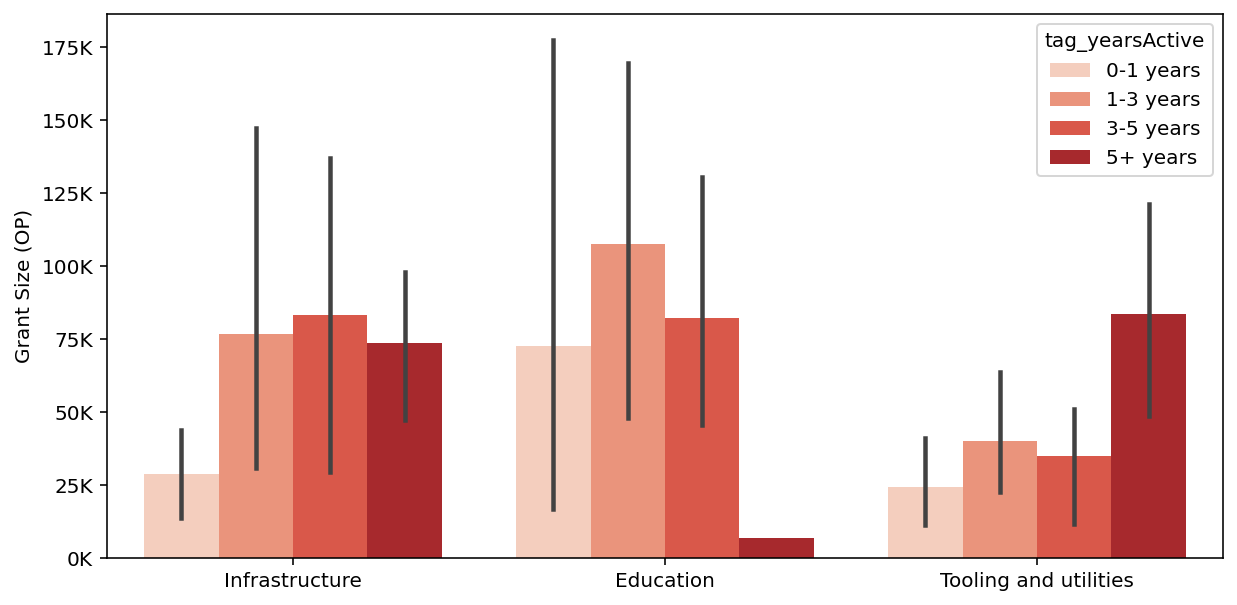

In [43]:
fig, ax = plt.subplots(figsize=(10,5), dpi=144, facecolor='white')
sns.barplot(
    data=canonical_df, 
    x='tag_grantCategory', 
    y='grant', 
    hue='tag_yearsActive', 
    hue_order=['0-1 years', '1-3 years', '3-5 years', '5+ years'],
    palette="Reds"
)
ax.set_yticklabels([f"{y/1000:.0f}K" for y in ax.get_yticks()])
ax.set_ylabel("Grant Size (OP)")
ax.set_xlabel("")

/var/folders/gh/1v87rt9j01gcjctn3v95bqkw0000gn/T/ipykernel_44440/42040708.py:22: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Text(0, 0.5, 'OP Grant per Team Member\n')

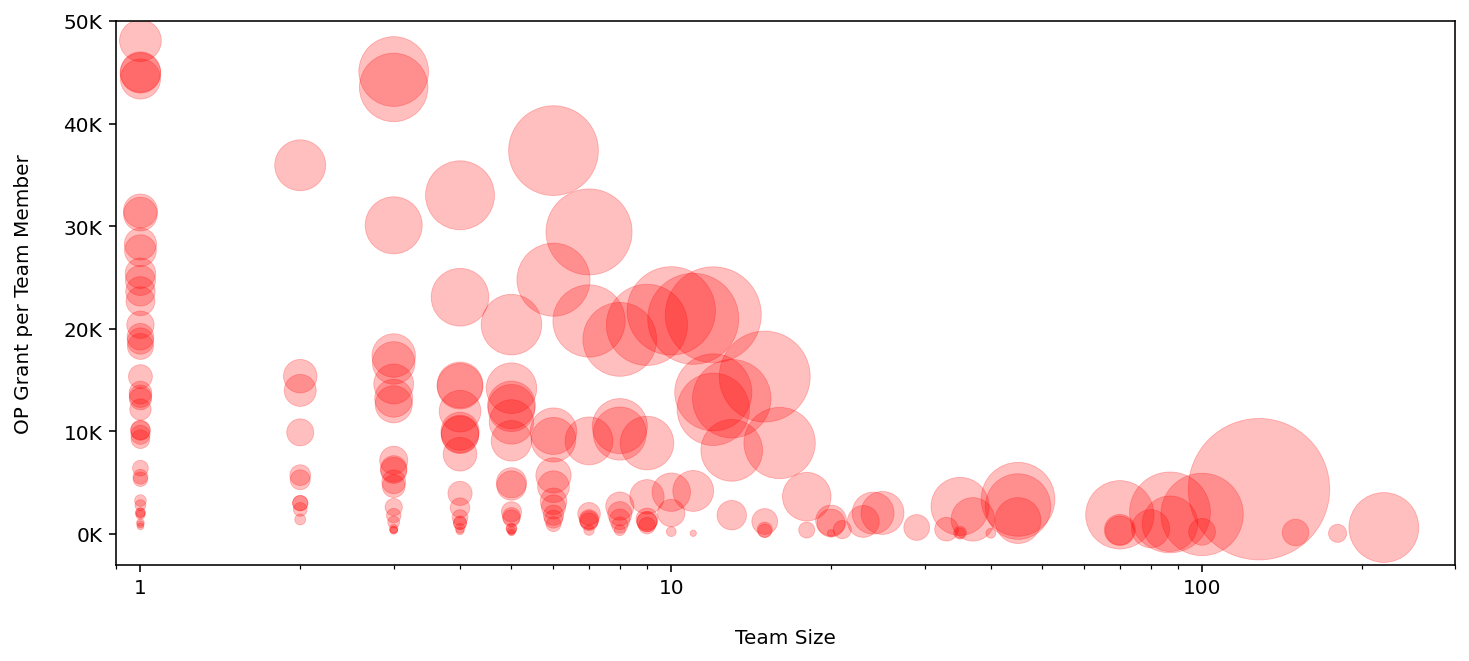

In [44]:
fig, ax = plt.subplots(figsize=(12,5), dpi=144, facecolor='white')
sns.scatterplot(
    x=canonical_df['team_selfReported'],
    y=(canonical_df['grant'] / canonical_df['team_selfReported']),
    size=canonical_df['grant'],
    color='Red',
    sizes=(10,5000),
    alpha=.25,
    legend=False,
    edgecolor='red',
    ax=ax
)
# sns.regplot(
#     x=canonical_df['team_selfReported'],
#     y=(canonical_df['grant'] / canonical_df['team_selfReported']),
#     scatter_kws = {"color": "red", "alpha": 0.0},
#     line_kws = {"color": "gray"},
#     ax=ax
# )
ax.set_xlim(.9,300)
ax.set_ylim(-3000,50000)
ax.set_yticklabels([f"{y/1000:.0f}K" for y in ax.get_yticks()])
ax.set_xscale('log')
ax.set_xticks([1,10,100])
ax.set_xticklabels([1,10,100])
ax.set_xlabel("\nTeam Size")
ax.set_ylabel("OP Grant per Team Member\n")

In [45]:
(canonical_df['grant'] / canonical_df['team_selfReported']).sort_values().head(30)

Project Name
Ankr                                47.797111
Questbook                           50.728000
NFTEarth                            54.023636
BwareLabs                           55.437500
RockX                               72.936000
Quark ID                           115.116000
Ospace                             118.852000
Messari Protocol Services          127.239067
WTF Academy                        194.190900
OAYC                               214.879000
GiveStation                        275.380000
Layer2DAO                          293.150000
Basic course in crypto literacy    300.252000
Solhint                            328.181429
MetricsDAO                         357.486250
ERC-5560: Redeemable NFTs          357.513333
Infinity Wallet & Web3 Browser     358.380000
Gov                                359.926667
Orbiter Finance                    372.029444
ITU Blockchain                     377.818857
EthereansOS                        399.344000
Nested               

In [46]:
canonical_df.loc['Flipside Crypto']

grant                                                             40079.68
profile_url              https://app.optimism.io/retropgf-discovery/0x6...
profile_address                 0x1ef753934C40a72a60EaB12A68B6f8854439AA78
profile_nominationUrl    https://gov.optimism.io/t/tooling-utilities-no...
profile_website                                https://flipsidecrypto.xyz/
profile_twitter                         https://twitter.com/flipsidecrypto
profile_github                           https://github.com/FlipsideCrypto
profile_description      Flipside Crypto has worked alongside the OP La...
profile_activities       Data & Analytics Suite\n- Core Optimism data t...
profile_funding          We sustain ourselves through the following eff...
profile_teamSize         Flipside Crypto is a team of 80 full-time empl...
github_owner                                                FlipsideCrypto
github_isOrg                                                          True
github_yearsActive       

/var/folders/gh/1v87rt9j01gcjctn3v95bqkw0000gn/T/ipykernel_44440/1155430126.py:36: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Text(0.5, 0, 'Team Size (Log Scale)')

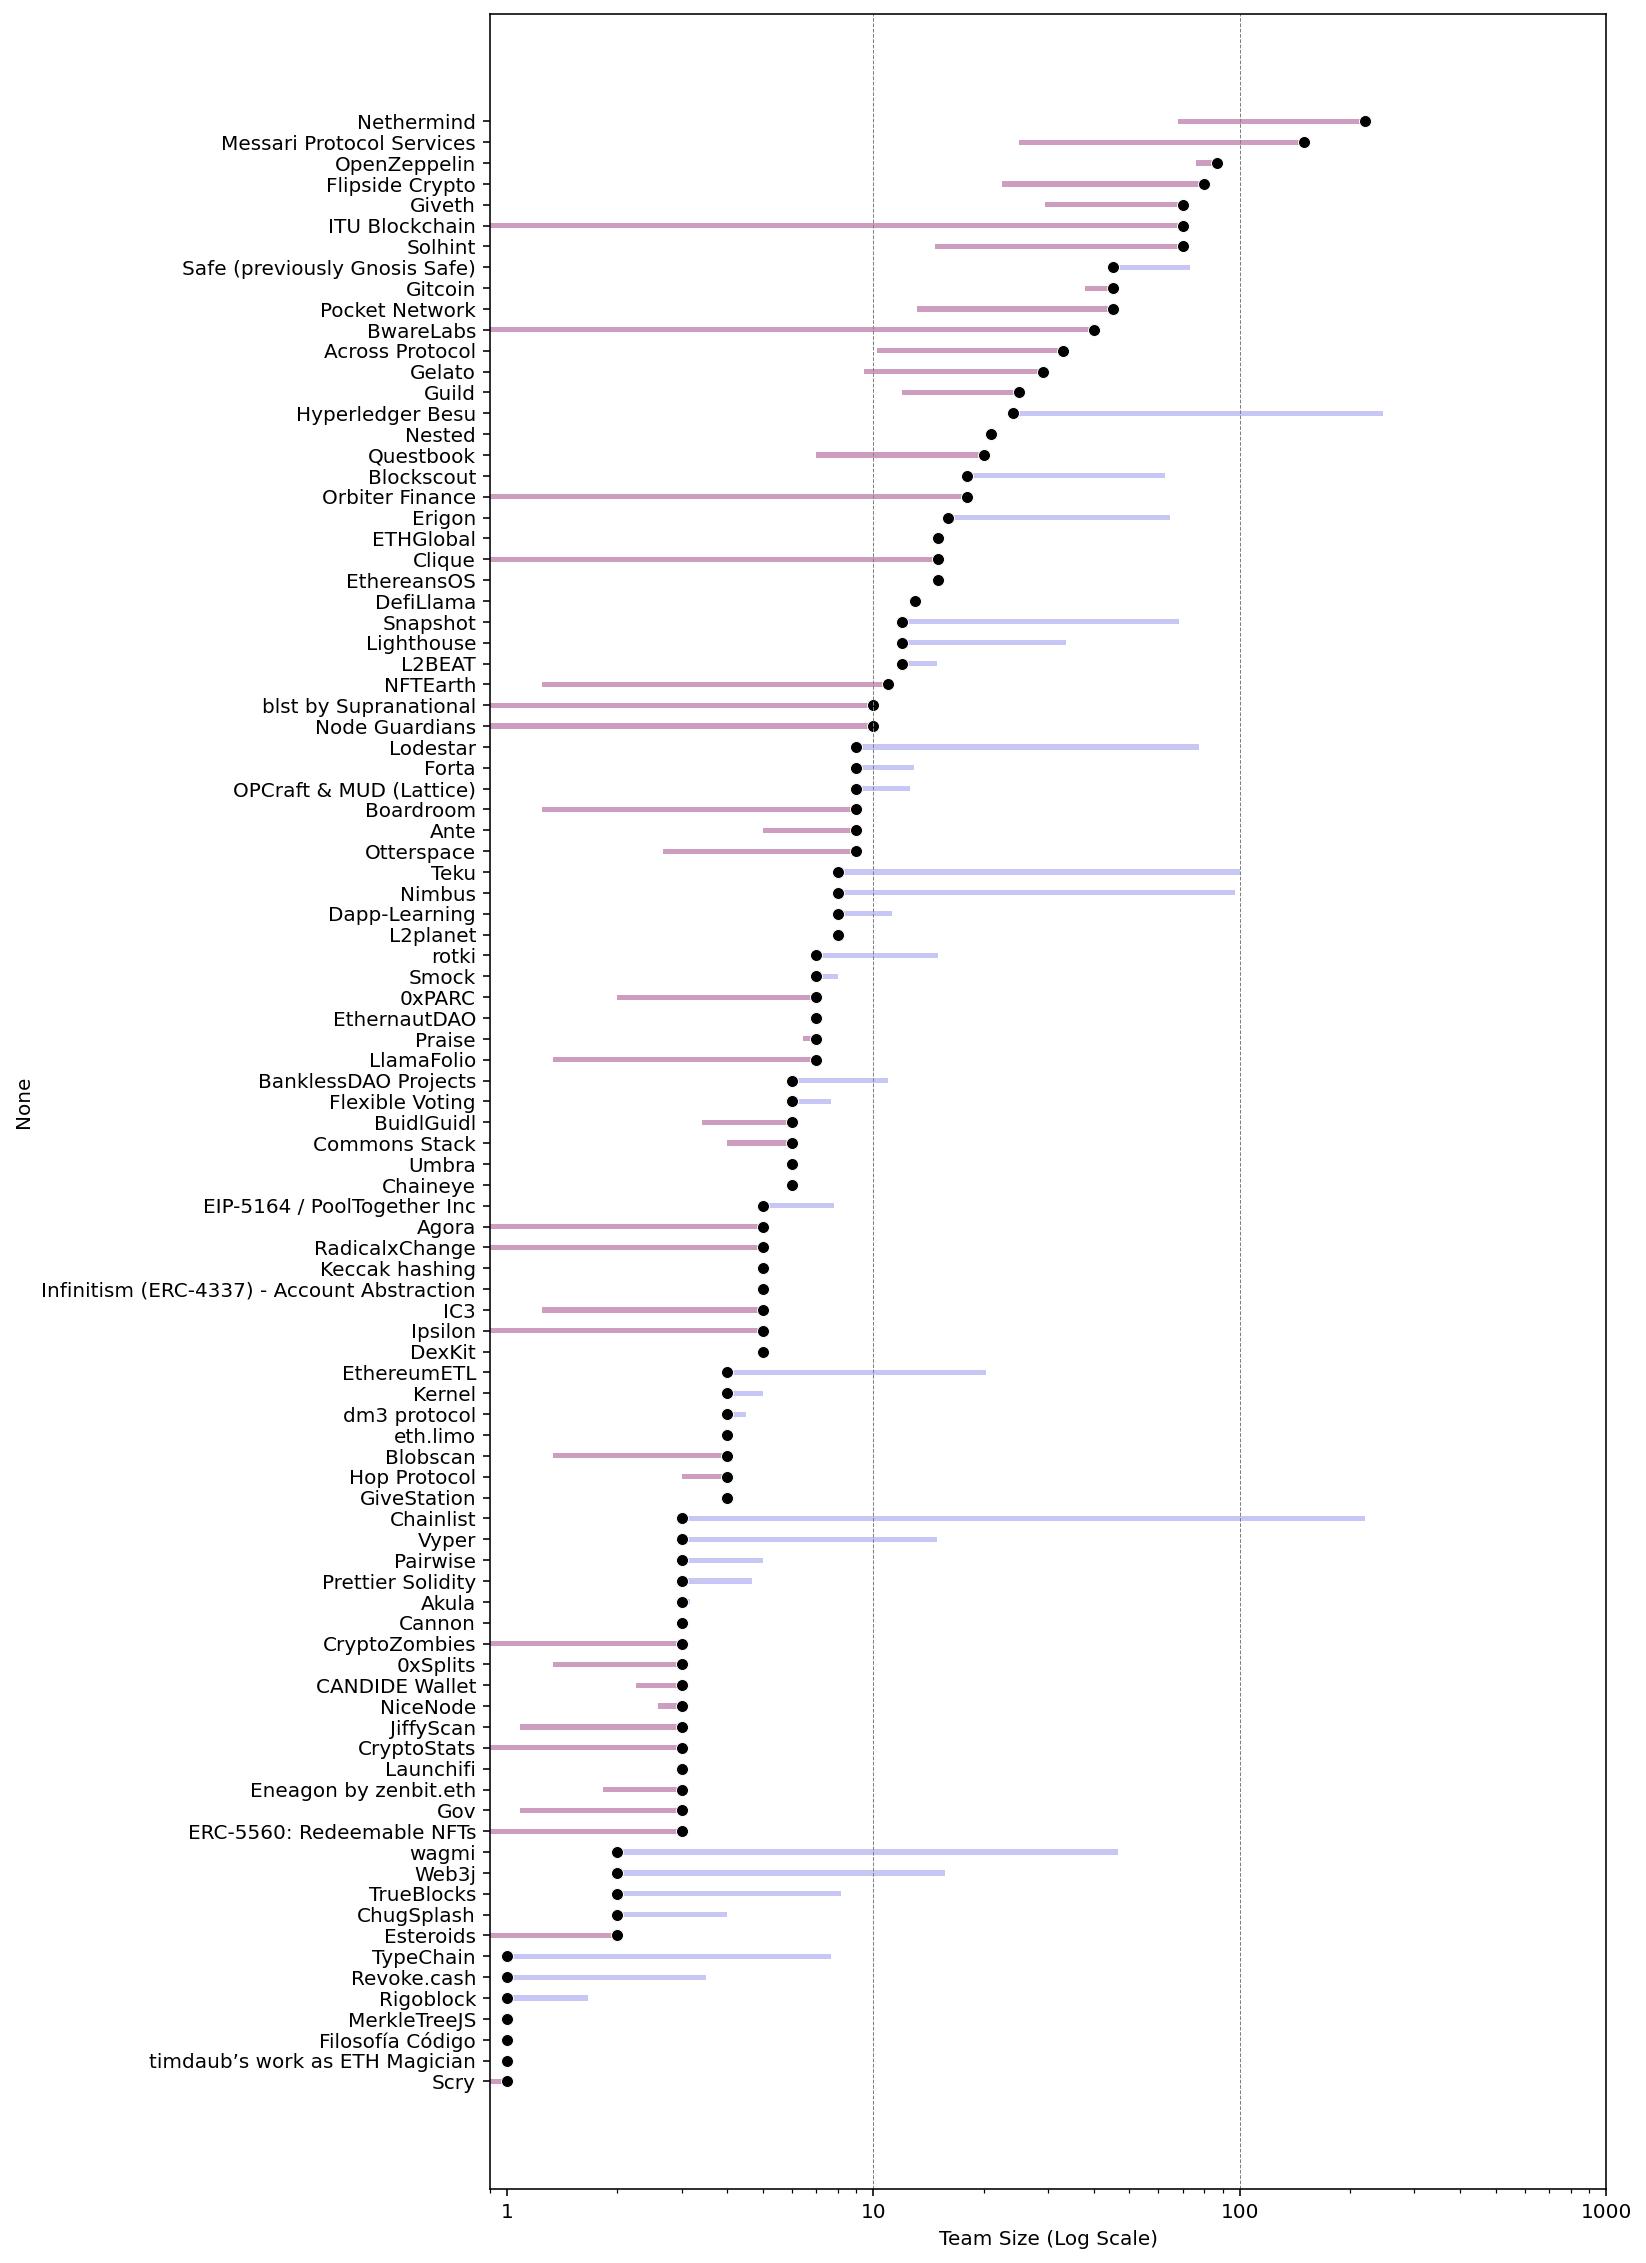

In [47]:
fig, ax = plt.subplots(figsize=(10,20), dpi=144, facecolor='white')

sns.barplot(
    y=teamsize_df.index,
    x=teamsize_df['Max'],
    color='blue',
    alpha=.25,
    width=.25,
    ax=ax
)
sns.barplot(
    y=teamsize_df.index,
    x=teamsize_df['Team Size Estimate'],
    color='red',
    alpha=.25,
    width=.25,
    ax=ax
)
sns.barplot(
    y=teamsize_df.index,
    x=teamsize_df['Min'],
    color='White',
    ax=ax
)
sns.scatterplot(
    y=teamsize_df.index, 
    x=teamsize_df['Team Size Estimate'],
    color='black'
)

ax.axvline(10, color='gray',linestyle='--',linewidth=.5)
ax.axvline(100, color='gray',linestyle='--',linewidth=.5)
ax.set_xticks([1,10,100,1000])
ax.set_xlim(.9,1000)
ax.set_xscale('log')
ax.set_xticklabels(["","",1,10,100,1000])
ax.set_xlabel("Team Size (Log Scale)")
# ax.set_ylabel("OP Grant per Active Contributor\n")

In [48]:
def label_projects(labels):
    op_mapping = dict(canonical_df['grant'])
    new_labels = []
    for x in labels:
        project = x.get_text()
        op = op_mapping.get(project)
        lbl = f"{project} ({op/1000:.0f}K)"
        new_labels.append(lbl)
    return new_labels

def contributor_heatmap(dataframe):
    
    fig, ax = plt.subplots(figsize=(15,len(dataframe)/3), dpi=144, facecolor='white')
    sns.heatmap(
        dataframe.applymap(np.sqrt), 
        mask=(dataframe<1),
        cmap='Reds', 
        linewidths=1,
        cbar=False,
        annot=dataframe,
        fmt=".0f"
    )
    ax.tick_params(
        axis='both', 
        which='major', 
        labelsize=12, 
        labelbottom = False, 
        bottom=False, 
        top = False, 
        labeltop=True
    )
    ax.set_yticklabels(label_projects(ax.get_yticklabels()))
    ax.set(xlabel=None, ylabel=None)
    
def activity_heatmap(dataframe):
    
    fig, ax = plt.subplots(figsize=(20,len(dataframe)/3), dpi=144, facecolor='white')
    sns.heatmap(
        dataframe.applymap(np.sqrt), 
        mask=(dataframe<1),
        cmap='Reds', 
        vmax=30,
        linewidths=1,
        cbar=False
    )
    ax.tick_params(
        axis='x', 
        which='major', 
        labelsize=12, 
        labelbottom = False, 
        bottom=False, 
        top=False, 
        labeltop=True,
        rotation=90
    )
    ax.set_yticklabels(label_projects(ax.get_yticklabels()))
    ax.set(xlabel=None, ylabel=None)
    for years in range(6):
        ax.axvline(12*years,color='k',linestyle='--',linewidth=.5)

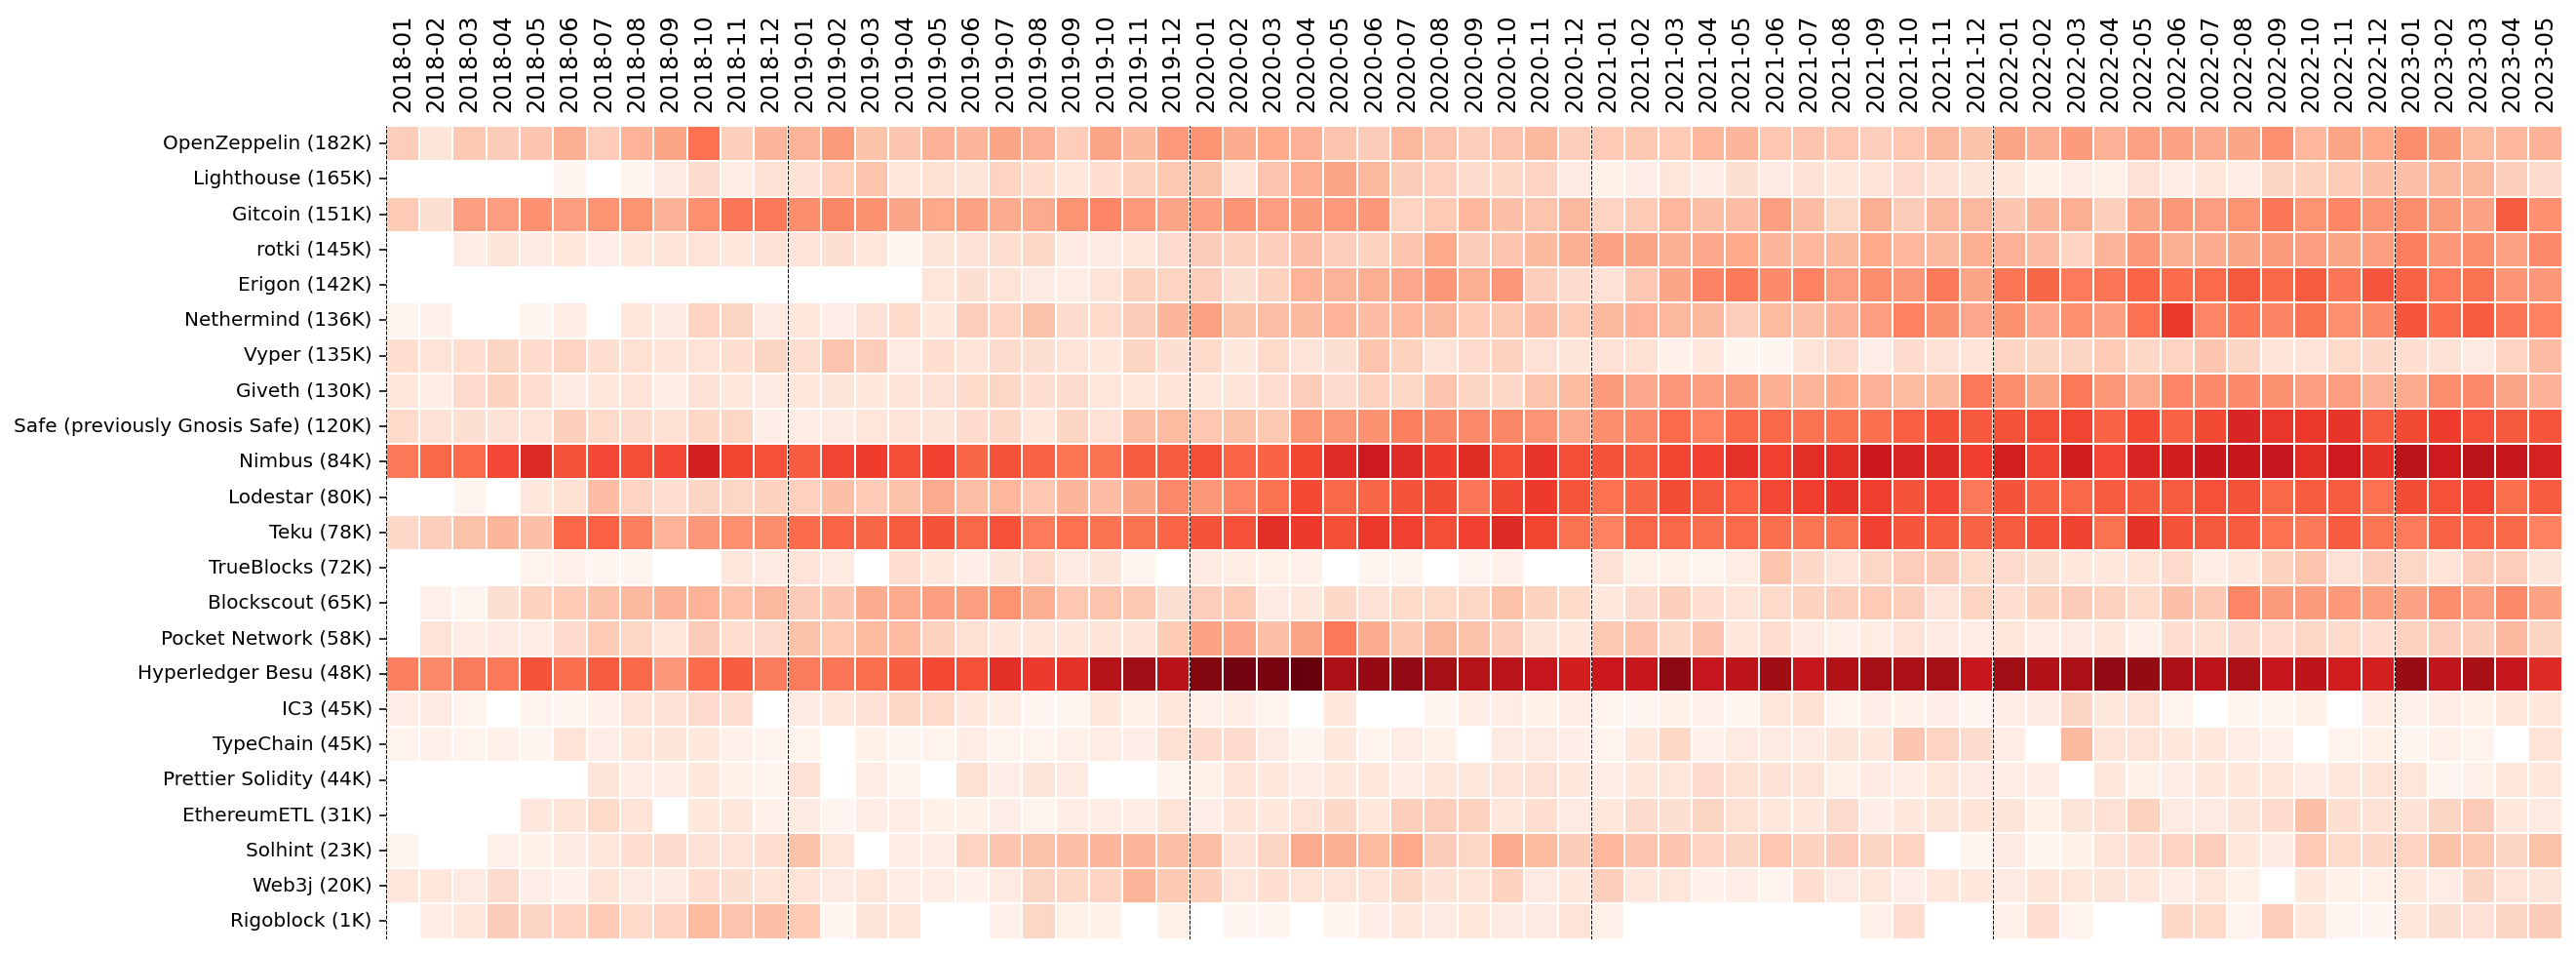

In [49]:
activity_heatmap(mprs.reindex(
    canonical_df[canonical_df['tag_momentum']=='Steady'].index
))

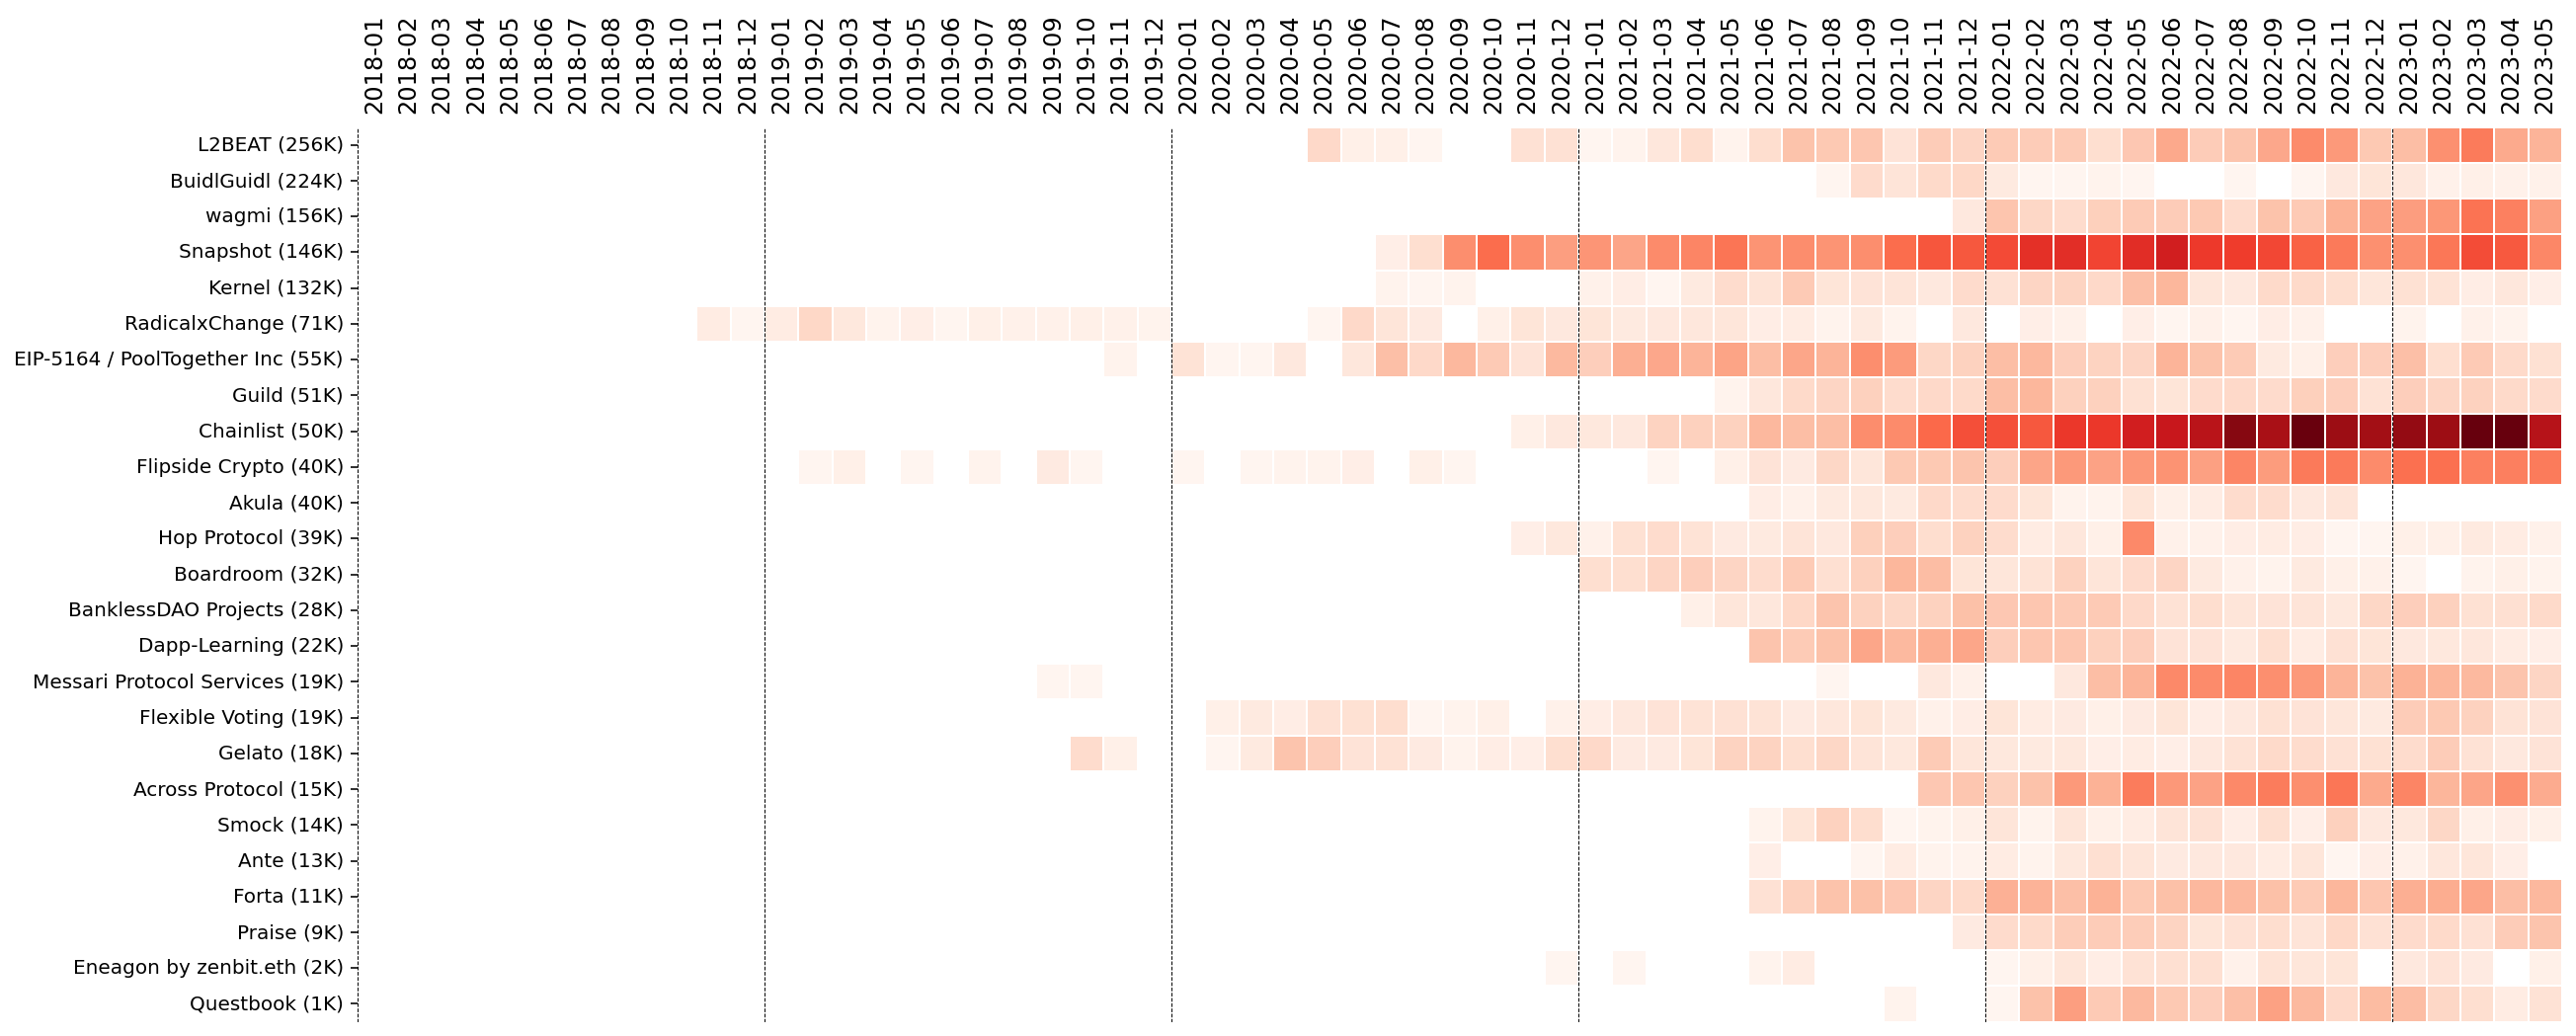

In [50]:
activity_heatmap(mprs.reindex(
    canonical_df[canonical_df['tag_momentum']=='Rising'].index
))

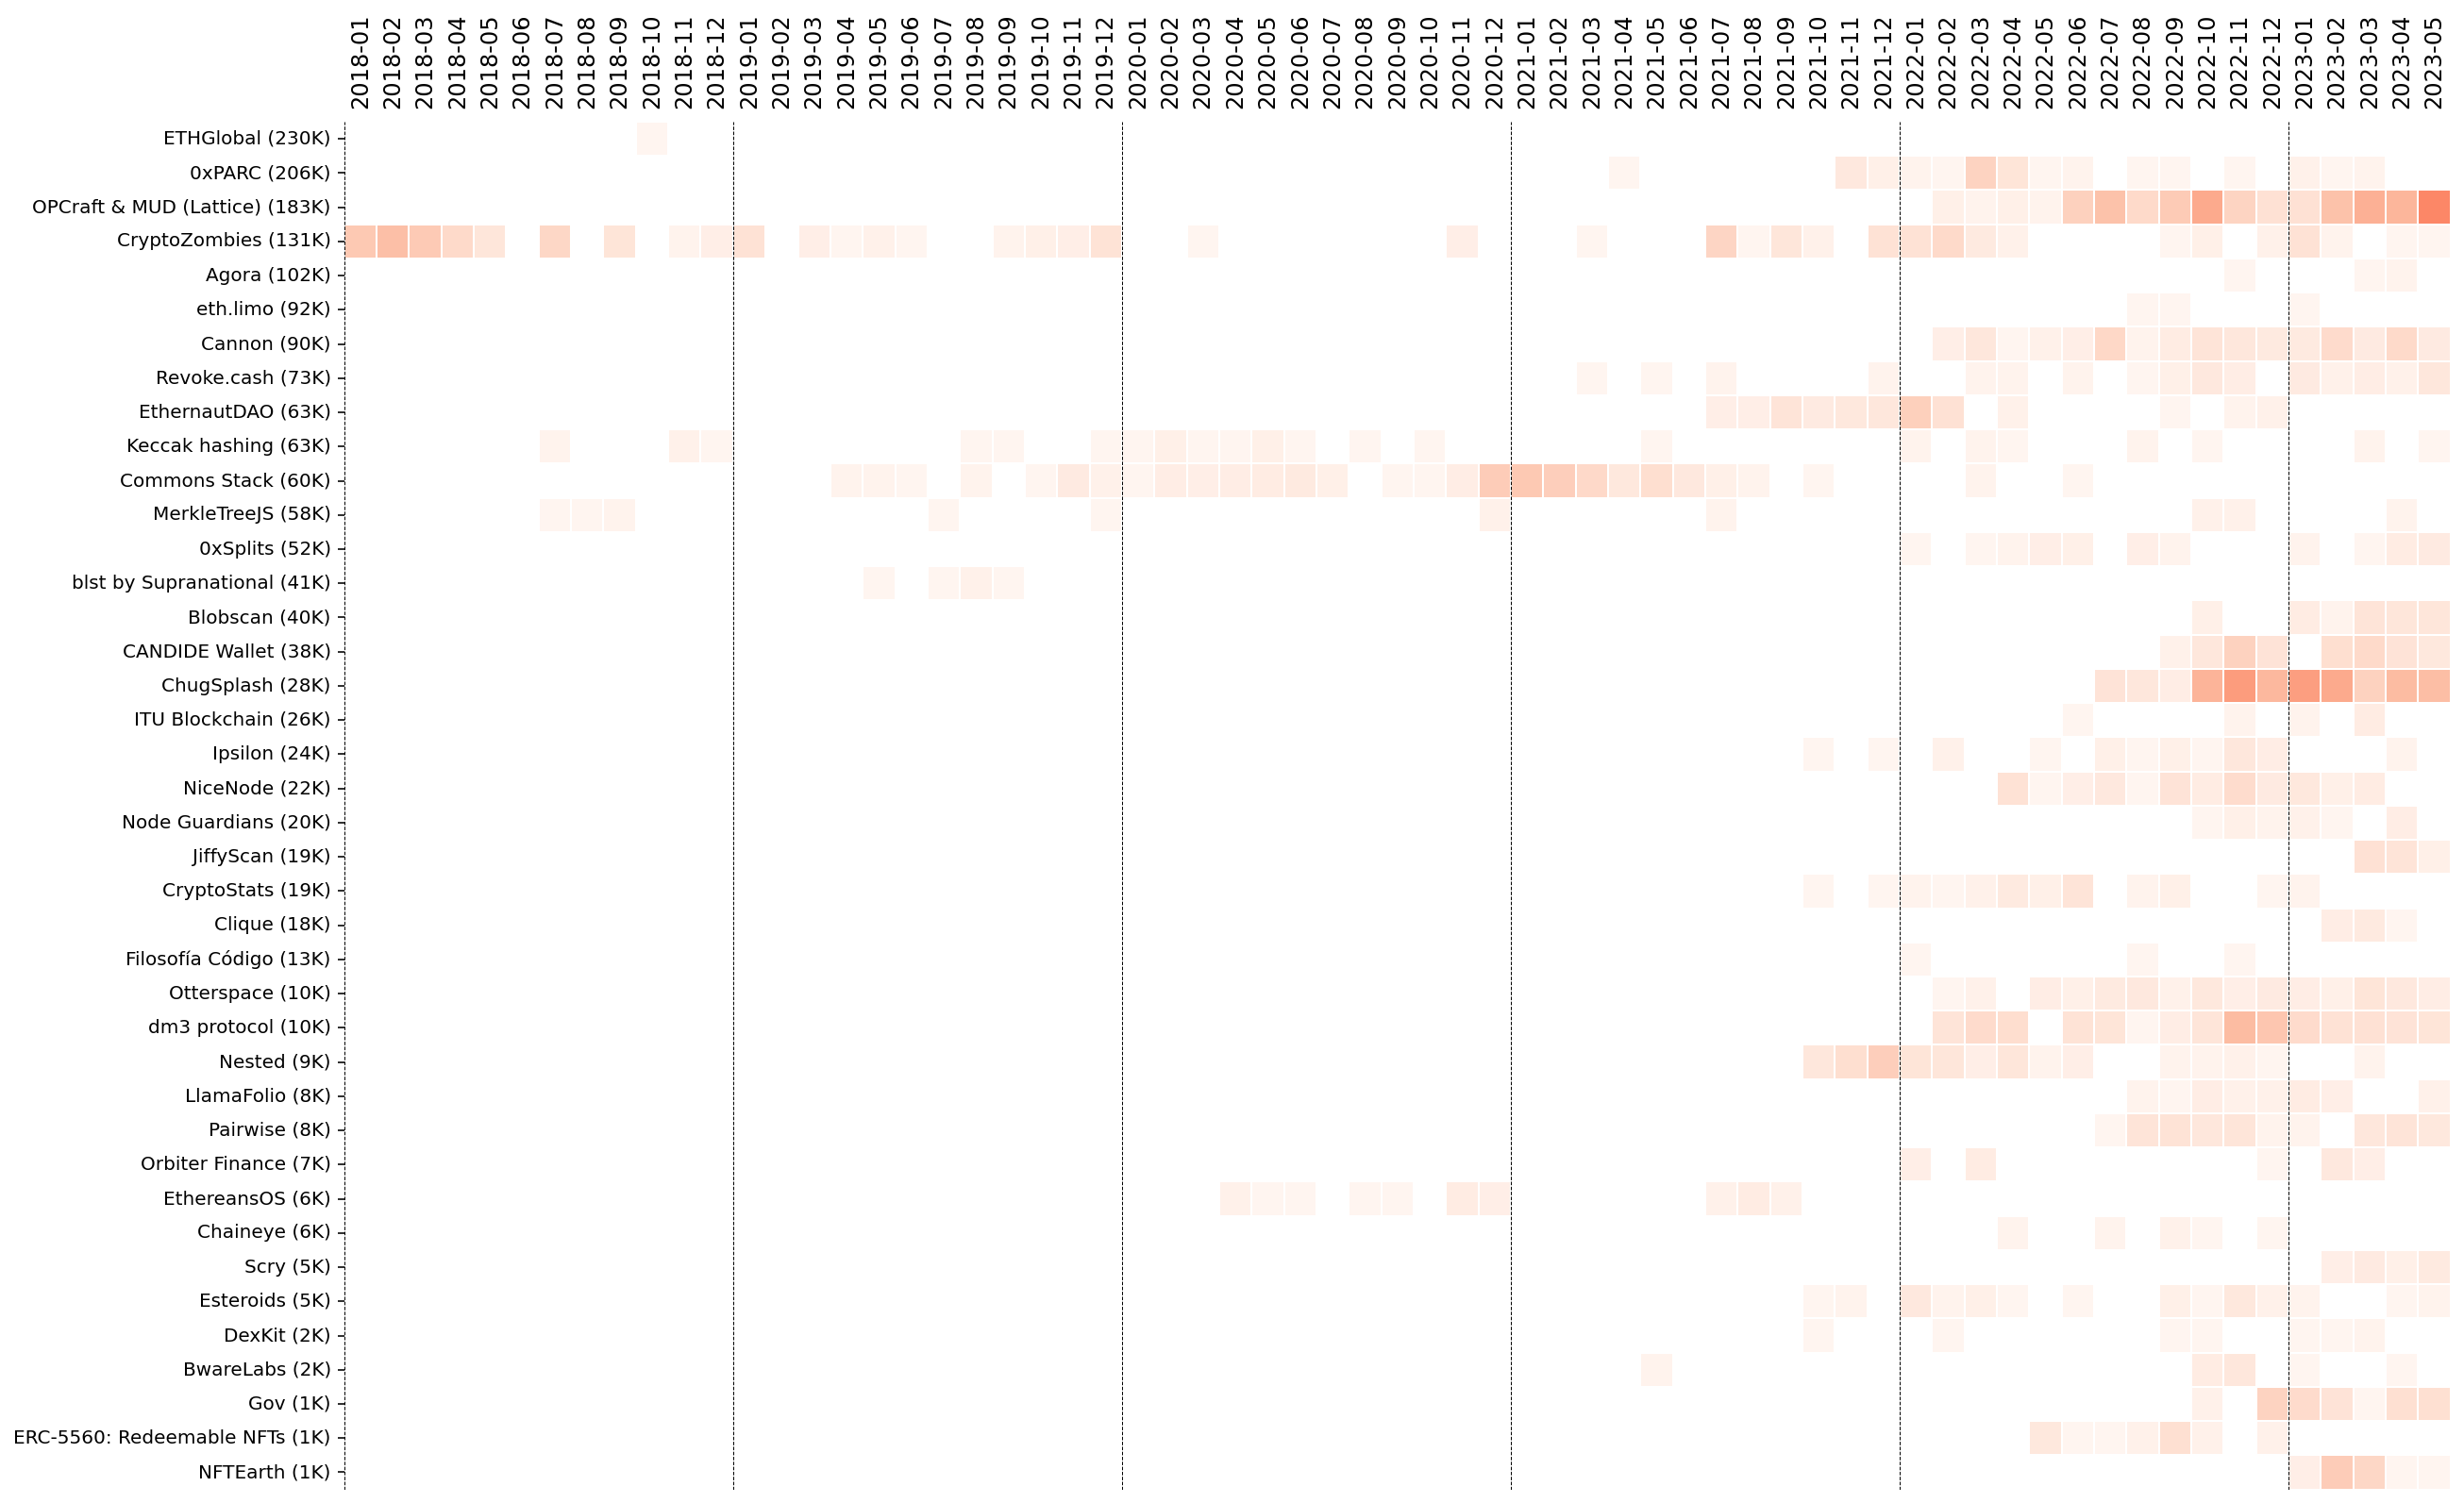

In [51]:
activity_heatmap(mprs.reindex(
    canonical_df[canonical_df['tag_momentum']=='Bursty'].index
))

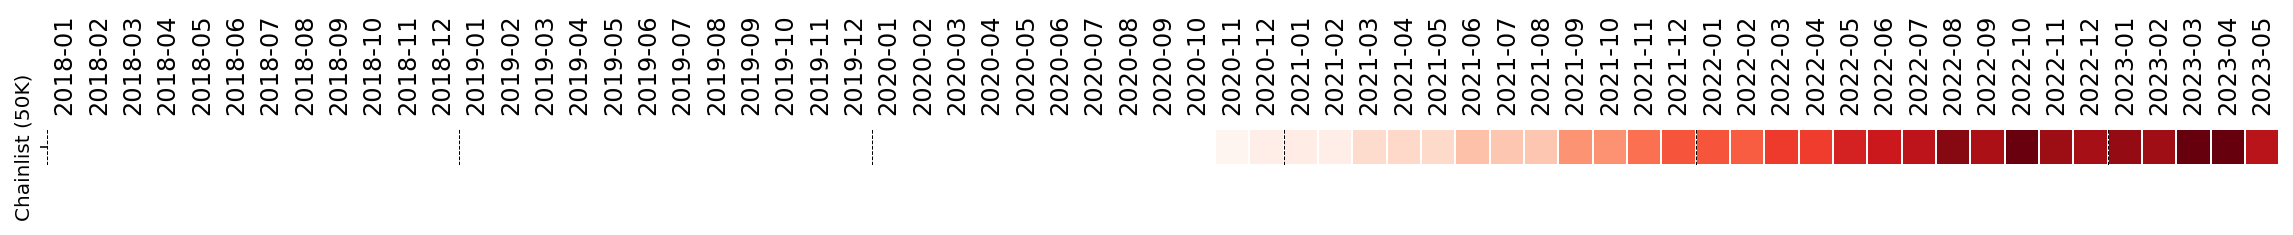

In [52]:
activity_heatmap(mprs.loc[['Chainlist']])

In [53]:
treemap(pathlist=['tag_entity', 'tag_grantCategory', 'tag_momentum', 'Project Name'], color_col='tag_momentum')

<Axes: xlabel='tag_yearsActive'>

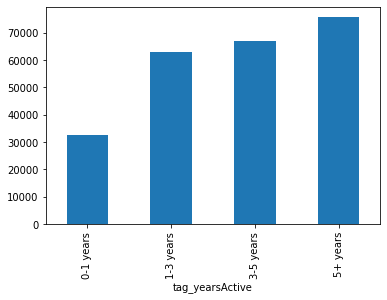

In [54]:
canonical_df.groupby('tag_yearsActive')['grant'].mean().plot(kind='bar')

In [55]:
canonical_df.loc['DefiLlama']

grant                                                            171292.71
profile_url              https://app.optimism.io/retropgf-discovery/0x3...
profile_address                 0x3754a10c1cA723961068B2653109E6201982Dd9c
profile_nominationUrl    https://gov.optimism.io/t/tooling-utilities-no...
profile_website                                     https://defillama.com/
profile_twitter                              https://twitter.com/defillama
profile_github                                https://github.com/DefiLlama
profile_description      DefiLlama is an OpenSource project that tracks...
profile_activities       - We provided the TVL metrics used by Optimism...
profile_funding          DefiLlama has only been funded through self-fu...
profile_teamSize                                  11 full-time, 2 interns.
github_owner                                                     DefiLlama
github_isOrg                                                          True
github_yearsActive       

In [56]:
treemap(
    pathlist=['tag_grantCategory','tag_entity', 'tag_yearsActive', 'tag_teamSize', 'tag_teamComposition', 'tag_momentum'],
    color_col='tag_grantCategory'
)
#canonical_df['tag_momentum']

# 8. Dump the dataframe

In [57]:
canonical_df.to_csv("data/RPGF2_analysis_export.csv")